In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, MinMaxScaler
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split

#Load Datasets

In [ ]:
books = pd.read_csv('/content/sample_data/books.csv')          # Goodbooks-10k
ratings = pd.read_csv('/content/sample_data/ratings.csv')

#Preprocess book features

In [ ]:
# Authors multi-hot
mlb_authors = MultiLabelBinarizer()
authors = books['authors'].str.split(',').fillna('')
author_features = mlb_authors.fit_transform(authors)

# Genres multi-hot (if column exists)
if 'genres' in books.columns:
    mlb_genres = MultiLabelBinarizer()
    genres = books['genres'].str.split(',').fillna('')
    genre_features = mlb_genres.fit_transform(genres)
else:
    genre_features = np.zeros((len(books),0))

# Title embeddings
from sentence_transformers import SentenceTransformer
model_title = SentenceTransformer('all-MiniLM-L6-v2')
title_embeddings = model_title.encode(books['title'].fillna(''))

# Numeric features
numerical_cols = ['original_publication_year','average_rating','ratings_count',
                  'work_ratings_count','work_text_reviews_count',
                  'ratings_1','ratings_2','ratings_3','ratings_4','ratings_5','books_count']
scaler_books = StandardScaler()
numerical_features_books = scaler_books.fit_transform(books[numerical_cols].fillna(0))

# Combine all book features
book_features = np.hstack([author_features, genre_features, title_embeddings, numerical_features_books])
book_features = tf.convert_to_tensor(book_features, dtype=tf.float32)
book_input_dim = book_features.shape[1]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

#Preprocess user and book indices

In [ ]:
# Compute user numeric features
user_stats = ratings.groupby('user_id').agg({
    'rating': ['mean', 'count']
}).reset_index()
user_stats.columns = ['user_id', 'avg_rating', 'num_ratings']

# Scale numeric features
scaler_users = StandardScaler()
user_numeric_features = scaler_users.fit_transform(user_stats[['avg_rating','num_ratings']])

# Map user_id to index
user_ids_unique = user_stats['user_id'].unique()
user_id_to_idx = {uid: idx for idx, uid in enumerate(user_ids_unique)}
num_users = len(user_ids_unique)
embedding_dim = 64  # increased embedding size

book_id_to_idx = {bid: idx for idx, bid in enumerate(books['book_id'])}


In [ ]:
user_input = []
book_input = []
user_numeric_input = []
y = []

for _, row in ratings.iterrows():
    user_idx = user_id_to_idx.get(row['user_id'])
    book_idx = book_id_to_idx.get(row['book_id'])
    if user_idx is not None and book_idx is not None:
        user_input.append(user_idx)
        book_input.append(book_features[book_idx])
        user_numeric_input.append(user_numeric_features[user_idx])
        y.append(row['rating'])

user_input = np.array(user_input)
book_input = np.array(book_input)
user_numeric_input = np.array(user_numeric_input)
y = np.array(y)

#Train-test split

In [ ]:
from sklearn.model_selection import train_test_split

X_train_user, X_test_user, X_train_book, X_test_book, X_train_user_num, X_test_user_num, y_train, y_test = train_test_split(
    user_input, book_input, user_numeric_input, y, test_size=0.2, random_state=42
)


#Build NN

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.models import Model

# User tower
user_input_layer = Input(shape=(), dtype=tf.int32, name='user_input')
user_embedding = Embedding(input_dim=num_users+1, output_dim=embedding_dim, name='user_embedding')(user_input_layer)
user_embedding = Flatten()(user_embedding)

user_numeric_input_layer = Input(shape=(2,), name='user_numeric_input')
u = Concatenate()([user_embedding, user_numeric_input_layer])
u = Dense(128, activation='relu')(u)
u = Dropout(0.2)(u)
u = Dense(64, activation='relu')(u)

# Book tower
book_input_layer = Input(shape=(book_input_dim,), name='book_input')
b = Dense(256, activation='relu')(book_input_layer)
b = Dropout(0.2)(b)
b = Dense(128, activation='relu')(b)
b = Dense(64, activation='relu')(b)

# Merge user and book towers
x = Concatenate()([u, b])
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='linear')(x)  # predict rating directly

model = Model(inputs=[user_input_layer, user_numeric_input_layer, book_input_layer], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 64)        │  3,419,200 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 64)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_numeric_input  │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ book_input          │ (None, 6524)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 66)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ user_numeric_inp… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │  1,670,400 │ book_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      8,576 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      2,080 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         33 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,157,953 (19.68 MB)

 Trainable params: 5,157,953 (19.68 MB)

 Non-trainable params: 0 (0.00 B)

#Normalise and train

In [ ]:
history = model.fit(
    [X_train_user, X_train_user_num, X_train_book],
    y_train,
    validation_data=([X_test_user, X_test_user_num, X_test_book], y_test),
    epochs=20,  # train longer
    batch_size=128
)


Epoch 1/20
499/499 ━━━━━━━━━━━━━━━━━━━━ 44s 82ms/step - loss: 2.1733 - mae: 1.0409 - val_loss: 0.6972 - val_mae: 0.6625
Epoch 2/20
499/499 ━━━━━━━━━━━━━━━━━━━━ 43s 87ms/step - loss: 0.6493 - mae: 0.6215 - val_loss: 0.6808 - val_mae: 0.6416
Epoch 3/20
499/499 ━━━━━━━━━━━━━━━━━━━━ 83s 88ms/step - loss: 0.5418 - mae: 0.5573 - val_loss: 0.7308 - val_mae: 0.6718
Epoch 4/20
499/499 ━━━━━━━━━━━━━━━━━━━━ 79s 83ms/step - loss: 0.4830 - mae: 0.5199 - val_loss: 0.7511 - val_mae: 0.6692
Epoch 5/20
499/499 ━━━━━━━━━━━━━━━━━━━━ 79s 78ms/step - loss: 0.4630 - mae: 0.5040 - val_loss: 0.7684 - val_mae: 0.6716
Epoch 6/20
499/499 ━━━━━━━━━━━━━━━━━━━━ 44s 84ms/step - loss: 0.4416 - mae: 0.4893 - val_loss: 0.8023 - val_mae: 0.7007
Epoch 7/20
499/499 ━━━━━━━━━━━━━━━━━━━━ 81s 83ms/step - loss: 0.4412 - mae: 0.4884 - val_loss: 0.7877 - val_mae: 0.6761
Epoch 8/20
499/499 ━━━━━━━━━━━━━━━━━━━━ 79s 77ms/step - loss: 0.4287 - mae: 0.4778 - val_loss: 0.7915 - val_mae: 0.6776
Epoch 9/20
499/499 ━━━━━━━━━━━━━━━━━━━━ 

#Predict and evaluate

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = model.predict([X_test_user, X_test_user_num, X_test_book], batch_size=512).flatten()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step
Test MSE: 0.9280
Test MAE: 0.7324


#Plot

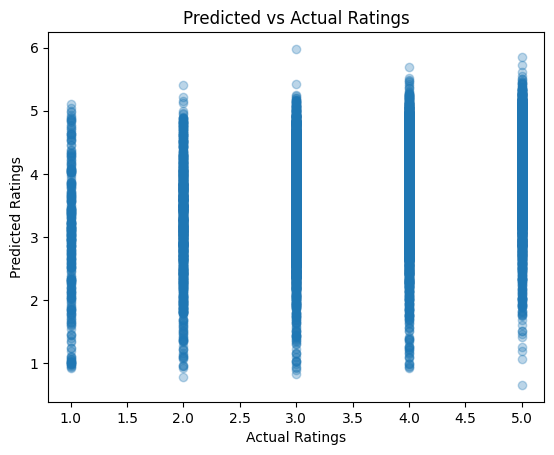

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Predicted vs Actual Ratings")
plt.show()


#Recommendation

* Problem:
Embedding layers only store vectors for users seen during training.
For a new user, there’s no embedding → the model cannot directly predict.
* Solution:
Use default/average user embedding or average numeric features for unseen users.
Optionally, if numeric features exist (like average rating), feed them to a dense tower.

For any new user, we can use avg_user_embedding as their vector in the dot product with book embeddings.

In [ ]:
# Average user embedding
user_embeddings_matrix = model.get_layer("user_embedding").get_weights()[0]
avg_user_embedding = np.mean(user_embeddings_matrix, axis=0)  # shape: (embedding_dim,)

# Default numeric features for new users
default_user_numeric = np.array([[3.5, np.median(user_numeric_features[:,1])]])  # avg rating, num ratings


Compute all book embeddings once to speed up recommendation - pre book

- book_embeddings is now a matrix we can dot with any user vector.

In [ ]:
# Book tower model
# We need to get the input tensor for the book tower and the output tensor
# of the last layer in the book tower before concatenation.
# Looking at the model summary, the book input layer is named 'book_input'
# and the last dense layer in the book tower before concatenation is 'dense_4'.

# Get the book input tensor from the main model's inputs
book_input_tensor = None
for input_tensor in model.inputs:
    if input_tensor.name.split('/')[0] == 'book_input':
        book_input_tensor = input_tensor
        break

if book_input_tensor is None:
    raise ValueError("Could not find the 'book_input' tensor in the model's inputs.")

# Get the output tensor of the last dense layer in the book tower
# Based on the model summary, 'dense_4' is the last dense layer in the book tower
book_tower_output_tensor = model.get_layer("dense_4").output


book_model = tf.keras.Model(
    inputs=book_input_tensor,
    outputs=book_tower_output_tensor
)

# Precompute all book embeddings
# Ensure book_features is a tensor with the correct dtype
book_features_tensor = tf.convert_to_tensor(book_features, dtype=tf.float32)
book_embeddings = book_model.predict(book_features_tensor, batch_size=512)  # shape: (num_books, 64)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


Efficient top-N recommendation function

In [ ]:
def build_recommender_simple(model, books, ratings, user_numeric_features, book_embeddings, top_n=10):
    """
    Simpler and faster two-tower recommender.
    - Precomputes user embeddings
    - Uses dot product for scoring
    """

    import numpy as np
    import tensorflow as tf

    # --- 1. Get user tower model ---
    user_input = model.get_layer('user_input').input
    user_numeric_input = model.get_layer('user_numeric_input').input
    user_tower_output = model.get_layer('dense_1').output
    user_tower_model = tf.keras.Model([user_input, user_numeric_input], user_tower_output)

    # --- 2. Map user_id -> embedding ---
    user_ids_unique = ratings['user_id'].unique()
    user_id_to_idx = {uid: idx for idx, uid in enumerate(user_ids_unique)}

    user_input_array = np.array([user_id_to_idx[uid] for uid in user_ids_unique])
    all_user_embeddings = user_tower_model.predict(
        [user_input_array, user_numeric_features],
        batch_size=512, verbose=0
    )
    avg_user_embedding = np.mean(all_user_embeddings, axis=0, keepdims=True)

    # --- 3. Map user -> rated books ---
    user_rated_books = ratings.groupby('user_id')['book_id'].apply(set).to_dict()

    # --- 4. Recommendation function ---
    def recommend_top_n(user_id=None, user_numeric=None):
        # Get embedding for known user
        if user_id in user_id_to_idx:
            u_idx = user_id_to_idx[user_id]
            user_emb = all_user_embeddings[u_idx:u_idx+1]
            rated_books = user_rated_books.get(user_id, set())
        else:
            # Cold start
            if user_numeric is not None:
                user_emb = user_tower_model.predict(
                    [np.array([0]), np.array(user_numeric).reshape(1, -1)],
                    verbose=0
                )
            else:
                user_emb = avg_user_embedding
            rated_books = set()

        # Compute scores via dot product
        scores = np.dot(book_embeddings, user_emb.T).flatten()

        # Mask out already rated books
        mask = np.array([bid not in rated_books for bid in books['book_id']])
        scores *= mask

        # Get top-N
        top_idx = np.argsort(scores)[::-1][:top_n]
        return books.iloc[top_idx][['title', 'authors']]

    return recommend_top_n, user_id_to_idx


In [ ]:
recommend_top_n(user_id=99999, user_numeric=[4.0, 15])

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


,title,authors
2,"Twilight (Twilight, #1)",Stephenie Meyer
9280,"Agamemnon (Oresteia, #1)","Aeschylus, Judith Affleck, Philip de May, Patr..."
596,Don Quixote,"Miguel de Cervantes Saavedra, Roberto González..."
292,Treasure Island,Robert Louis Stevenson
1440,My Life in France,"Julia Child, Alex Prud'Homme"
1298,Still Life with Woodpecker,Tom Robbins
1387,The Last Juror,John Grisham
4,The Great Gatsby,F. Scott Fitzgerald
1141,Cryptonomicon,Neal Stephenson
4148,"The Oresteia (Ορέστεια, #1-3)","Aeschylus, Robert Fagles, William Bedell Stanford"


In [ ]:
recommend_top_n(user_id=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


,title,authors
2,"Twilight (Twilight, #1)",Stephenie Meyer
1298,Still Life with Woodpecker,Tom Robbins
9537,Agent to the Stars,John Scalzi
1387,The Last Juror,John Grisham
4871,Villa Incognito,Tom Robbins
3254,The Beautiful and Damned,F. Scott Fitzgerald
1852,Memories of My Melancholy Whores,"Gabriel García Márquez, Edith Grossman"
6662,The Taste of Home Cookbook,"Janet Briggs, Beth Wittlinger"
8293,The Android's Dream,John Scalzi
662,A People's History of the United States,Howard Zinn
